# Evaluation

In [4]:
import os
import pandas as pd
import numpy as np

import math

import sklearn

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, LabelBinarizer

In [8]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
np.random.seed(42)

diabetic = pd.read_csv('training/diabetes/diabetic_data_balanced.csv')

# Anonymise
diabetic = diabetic.groupby('patient_nbr', group_keys=False) \
                    .apply(lambda df: df.sample(1))


# Train test split
X, y = diabetic.drop('readmitted', axis=1), diabetic['readmitted']

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(X, y):
     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [9]:
# PREPROCESSING PIPELINE
diabetic_num_to_cat_features = ['admission_type_id', 'discharge_disposition_id','admission_source_id']

diabetic_cat_to_num_features = ['max_glu_serum', 'A1Cresult']

diabetic_num_features = ['time_in_hospital', 'num_lab_procedures','num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

diabetic_drugs = []

diabetic_cat_features = ['race', 'gender', 'change', 'diabetesMed']
diabetic_diag_features = ['diag_1', 'diag_2', 'diag_3']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(diabetic_num_features)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

age_pipeline = Pipeline([
    ('selector', DataFrameSelector(['age'])),
    ('ordinal_encoder', OrdinalEncoder(categories=[['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']])),
    ('std_scaler', StandardScaler()),
])

class DiagEncoder(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = OneHotEncoder(*args, **kwargs, categories='auto', sparse=False)
    def fit(self, X, y=0):
        X = [[self.get_type(icd_str) for icd_str in x] for x in X]
        self.encoder.fit(X)
        return self
    def transform(self, X, y=0):
        X = [[self.get_type(icd_str) for icd_str in x] for x in X]
        return self.encoder.transform(X)
    def get_type(self, icd_str):
        if isinstance(icd_str, float) and math.isnan(icd_str):
            return('missing')
        elif icd_str.isnumeric():
            icd = int(icd_str)
        elif icd_str[:3].isnumeric():
            icd = int(icd_str[:3])
        else:
            return 'other'

        if (icd >= 390 and icd <= 459 or icd == 785):
            return 'circulatory'
        elif (icd >= 520 and icd <= 579 or icd == 787):
            return 'digestive'
        elif (icd >= 580 and icd <= 629 or icd == 788):
            return 'genitourinary'
        elif (icd == 250):
            return 'diabetes'
        elif (icd >= 800 and icd <= 999):
            return 'injury'
        elif (icd >= 710 and icd <= 739):
            return 'musculoskeletal'
        elif (icd >= 140 and icd <= 239):
            return 'neoplasms'
        elif (icd >= 460 and icd <= 519 or icd == 786):
            return 'respiratory'
        else:
            return 'other'
        

diag_pipeline = Pipeline([
    ('selector', DataFrameSelector(diabetic_diag_features)),
    ('diag_encoder', DiagEncoder()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(diabetic_num_to_cat_features + diabetic_cat_features + diabetic_drugs + diabetic_cat_to_num_features)),
    ('imputer', SimpleImputer(strategy='constant')),
    ('encoder', OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore'))

])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ('age_pipeline', age_pipeline),
    ('diag_pipeline', diag_pipeline),
    ("cat_pipeline", cat_pipeline),
])


X_train = full_pipeline.fit_transform(X_train)

In [10]:
# MACHINE LEARNING ALGORITHMS
print(X_train.shape)

tpot_best_clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=10, max_features=0.2, min_samples_leaf=1, min_samples_split=14, n_estimators=100, subsample=0.9000000000000001, random_state=42)
tpot_best_clf.fit(X_train, y_train)

(7149, 93)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=10,
                           max_features=0.2, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=14,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=0.9000000000000001,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [11]:
X_test_prepared = full_pipeline.transform(X_test)
print(X_test_prepared.shape)

(795, 93)


In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(tpot_best_clf.predict(X_test_prepared), y_test)

0.5547169811320755

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(tpot_best_clf, X_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

array([[1081,  220,  809],
       [ 364,  471, 1362],
       [ 185,  245, 2412]])

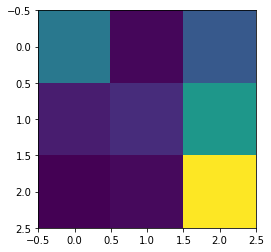

In [15]:
import matplotlib
from matplotlib import pyplot as plt

plt.imshow(confusion_matrix(y_train, y_train_pred))
plt.show()

Most confusion on the `>30` case which gets confused with `NO`. The `NO` case is the easiest to predict. 

In general the classifier tends to predict `NO` more often than it should, which is especially true for the `>30` case.

Probably `>30` and `NO` also have closer distributions because over 30 days might include many years where the patient is healthy most of the time, just like the not readmitted patient is.

In [16]:
y_train

3707    >30
7815    <30
1312    <30
4684    <30
4337    >30
       ... 
4507    >30
6630     NO
4946    >30
3980     NO
1620    >30
Name: readmitted, Length: 7149, dtype: object

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_train, y_train_pred, average='macro')
recall = recall_score(y_train, y_train_pred, average='macro')
f1 = f1_score(y_train, y_train_pred, average='macro')
print(precision, recall, f1)

0.5642293778501007 0.5251345415657841 0.5094807066933013


In [18]:
y_scores = cross_val_predict(tpot_best_clf, X_train, y_train, cv=5, method="decision_function")
y_scores

array([[-1.487472  , -1.0958428 , -0.84980644],
       [-1.47986559, -1.19732209, -0.57188739],
       [-1.45001841, -1.13507375, -0.82724366],
       ...,
       [-1.04753948, -0.76503083, -1.34091798],
       [-1.34950635, -1.10219947, -0.87840222],
       [-1.38931385, -1.18671745, -0.80668251]])

In [19]:
y_scores.shape

(7149, 3)

In [33]:
y_train_prepared

dtype('int64')

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_train_prepared = LabelBinarizer().fit_transform(y_train)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_prepared[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_prepared.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

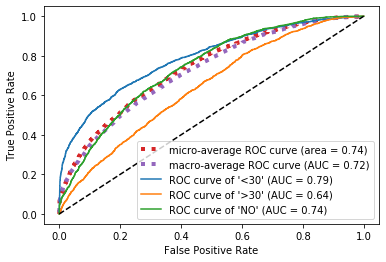

In [49]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

import seaborn as sns
current_palette = sns.color_palette()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color=current_palette[n_classes], linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color=current_palette[n_classes+1], linestyle=':', linewidth=4)


colors = cycle([current_palette[i] for i in range(n_classes)])

classes = ['<30', '>30', 'NO']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of \'{0}\' (AUC = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="best")
plt.show()

In [43]:
import seaborn as sns
current_palette = sns.color_palette()

In [44]:
current_palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]